In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
from tqdm.notebook import tqdm

In [2]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained("facebook/dinov2-small")
model = model.to("mps")

In [3]:
target_img = Image.open("./grant-headshot.png")

In [44]:
def get_img_vects(imgs):
    inputs = processor(images=imgs, return_tensors="pt")
    inputs = {k: v.to("mps") for k, v in inputs.items()}
    outputs = model(**inputs)
    # vects = outputs.last_hidden_state.mean(axis=1).detach().cpu().numpy()
    vects = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    # normalize
    vects /= np.linalg.norm(vects, axis=1, keepdims=True)
    return vects

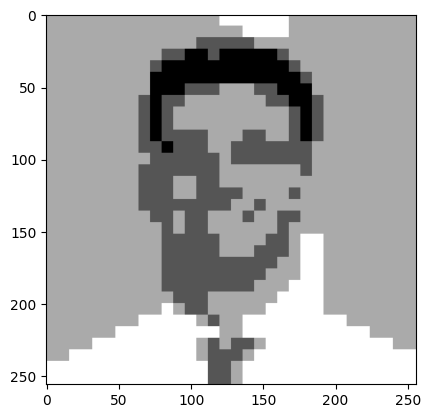

In [88]:
n_pallet = 4

t_target_img = Image.fromarray(np.array(target_img.resize((32, 32)).resize((256, 256), Image.BOX).convert("L")) // (256 // n_pallet) * (256 // n_pallet))


plt.imshow(t_target_img, cmap="gray")

In [89]:
target_vect = get_img_vects(t_target_img)[0]

In [91]:
def make_child_img_array(parent_1, parent_2):
    # crossover_point = np.random.randint(0, parent_1.shape[0])
    # child = np.concatenate([parent_1[:crossover_point], parent_2[crossover_point:]])
    # mutation_mask = np.random.random(size=child.shape) < mutation_rate
    # mutation = np.random.randint(2, size=child.shape, dtype=np.uint8)
    # child = np.where(mutation_mask, mutation, child)
    # return child
    mutation_rate = np.random.uniform(0, 0.1)
    crossover_points = np.random.randint(0, parent_1.shape[0], 3)
    crossover_points.sort()
    child = parent_1.copy()
    for i, crossover_point in enumerate(crossover_points):
        parent = parent_2 if i % 2 == 0 else parent_1
        child[crossover_point:] = parent[crossover_point:]

    mutation_mask = np.random.random(size=child.shape) < mutation_rate
    mutation = np.random.randint(2, size=child.shape, dtype=np.uint8)
    child = np.where(mutation_mask, mutation, child)

    return child


In [92]:
adam_and_eve = np.load("./ga/top_candidates.npy")

In [93]:
sample_indices = np.random.choice(2000, 500, replace=False)
adam_and_eve = adam_and_eve.reshape(2000, -1)[sample_indices]

In [94]:
initial_population_size = 500
img_size = 32

best_of_generation = []
top_scores = []

population = adam_and_eve
pbar = tqdm(total=100)


for i in range(100):
    scores = []
    batch_size = 8
    for i in range(0, initial_population_size, batch_size):
        batch_imgs = [
            Image.fromarray((img.reshape(img_size, img_size) * 255)).resize(
                (256, 256), Image.BOX
            ).convert("L")
            for img in population[i : i + batch_size]
        ]
        batch_vects = get_img_vects(batch_imgs)
        batch_scores = np.dot(batch_vects, target_vect)
        # batch_scores = ((batch_vects - target_vect) ** 2).mean(axis=-1).mean(axis=-1)
        scores.extend(batch_scores)

    # select top 10% of population
    n10 = int(initial_population_size * 0.1)
    top_10_args = np.argsort(scores)[::-1][:n10]
    top_10 = population[top_10_args]
    best_of_generation.append(population[top_10_args[0]])
    top_scores.append(scores[top_10_args[0]])

    pbar.update(1)
    pbar.set_description(f"Best score: {scores[top_10_args[0]]:.3f}")

    # create new population
    new_population = []
    for i in range(initial_population_size):
        parent_1 = top_10[np.random.randint(n10)]
        parent_2 = top_10[np.random.randint(n10)]
        new_population.append(make_child_img_array(parent_1, parent_2))

    population = np.array(new_population)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

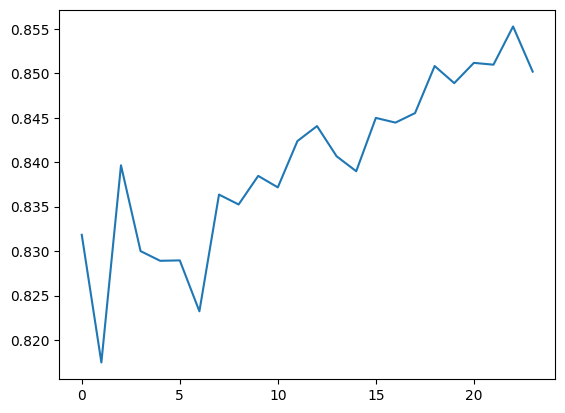

In [95]:
plt.plot(top_scores)
plt.show()

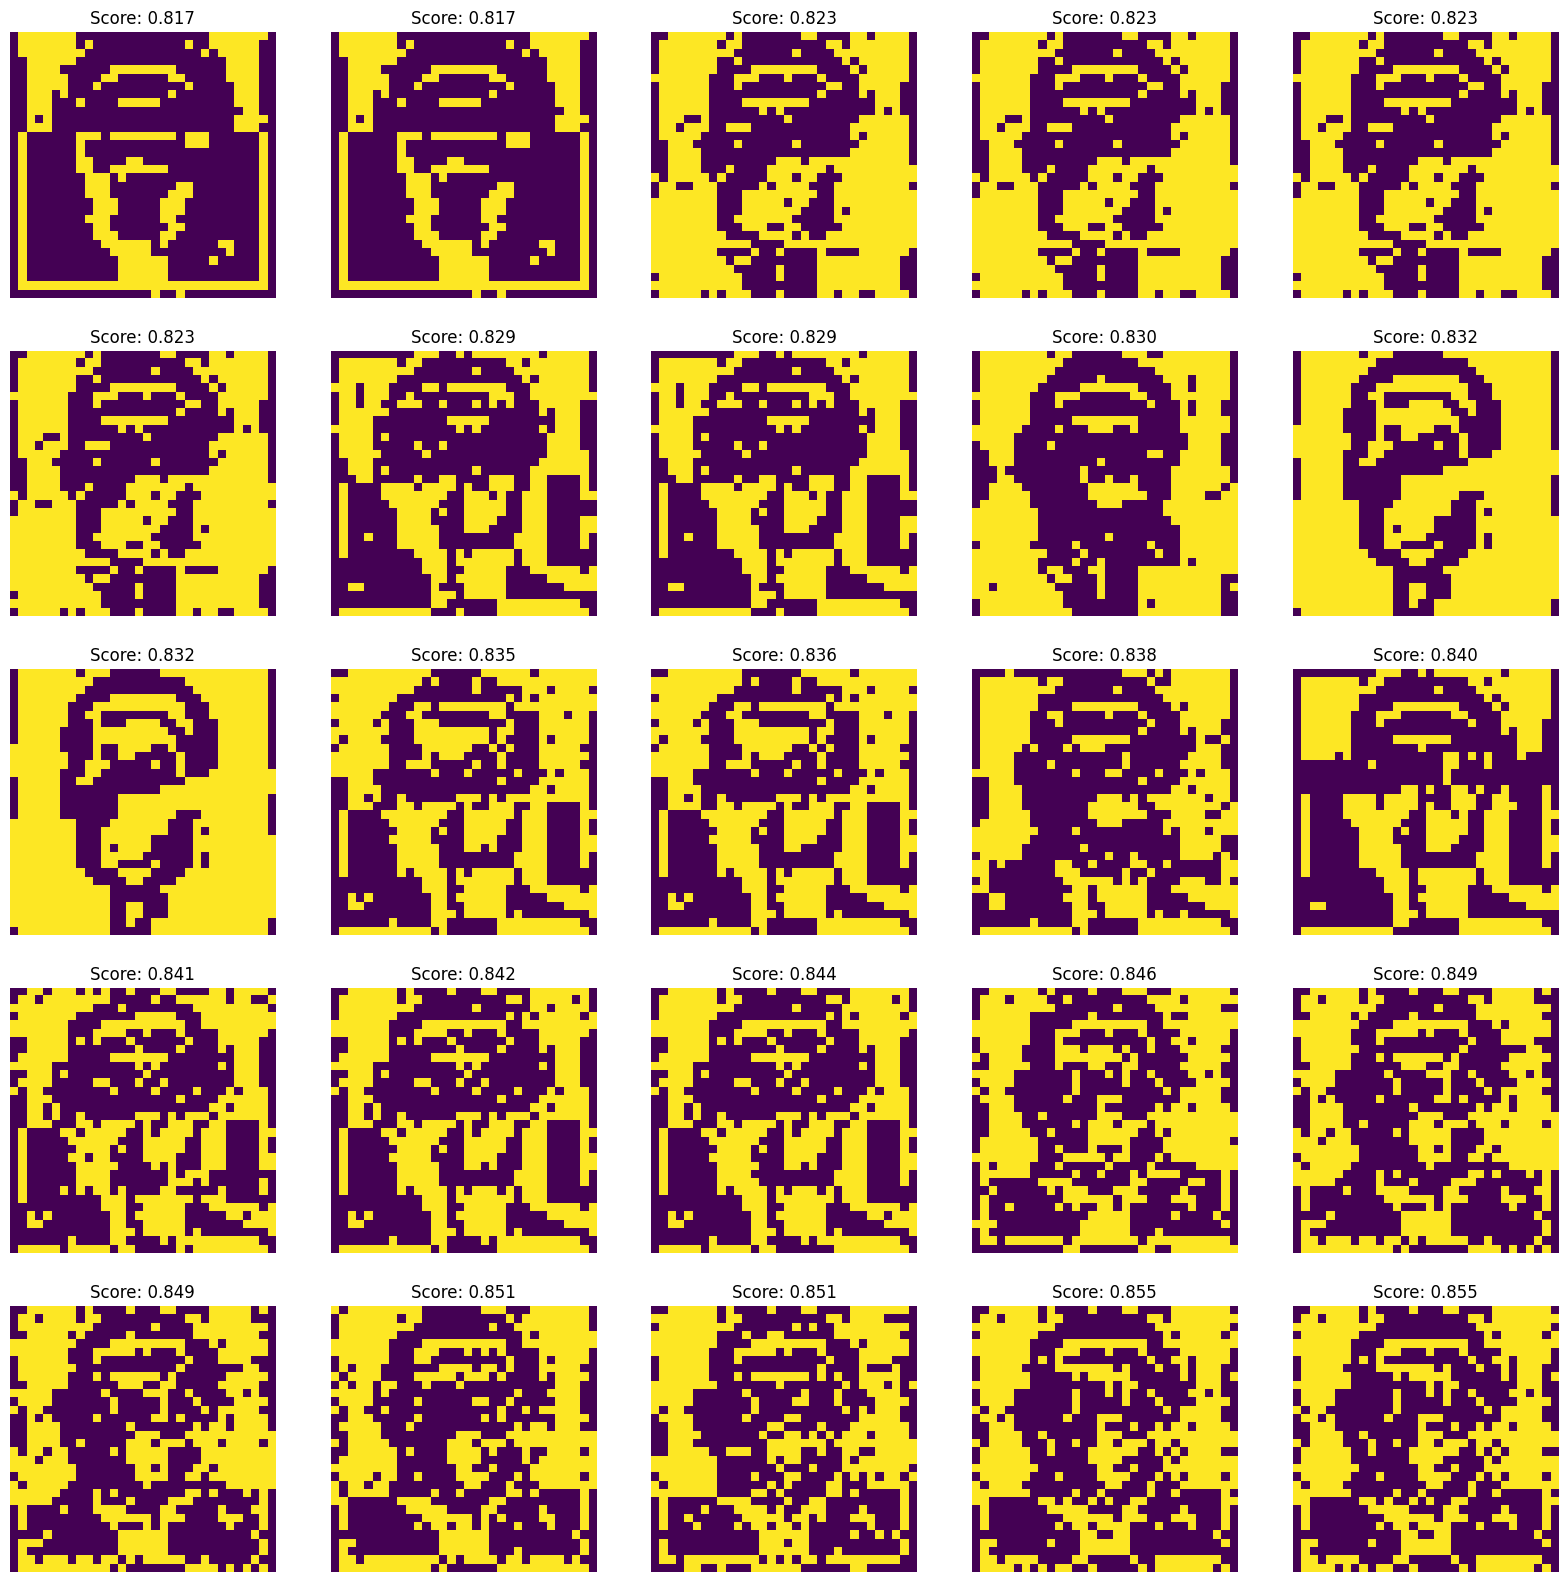

In [96]:
score_space = np.linspace(min(top_scores), max(top_scores), 25)
gen_space = [np.argmin(np.abs(top_scores - score)) for score in score_space]

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(Image.fromarray(best_of_generation[gen_space[i]].reshape(img_size, img_size)))
    ax.axis("off")
    ax.set_title(f"Score: {top_scores[gen_space[i]]:.3f}")
plt.show()

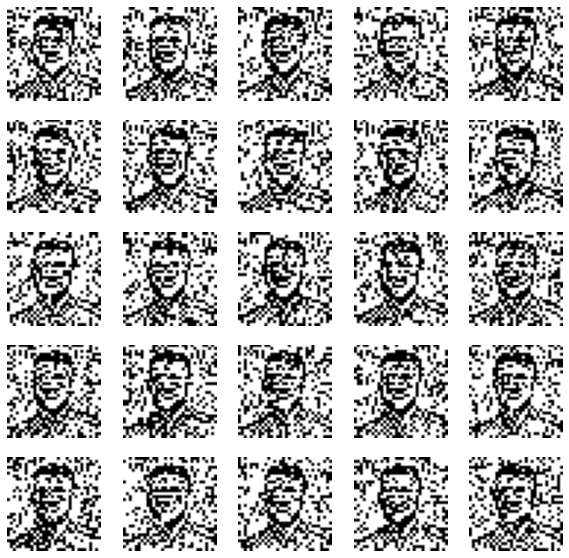

In [21]:
# sample 25 images from the last population and display them (5x5 grid)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    j = np.random.randint(initial_population_size)
    ax.imshow(population[j].reshape(img_size, img_size), cmap="gray")
    ax.axis("off")
plt.show()

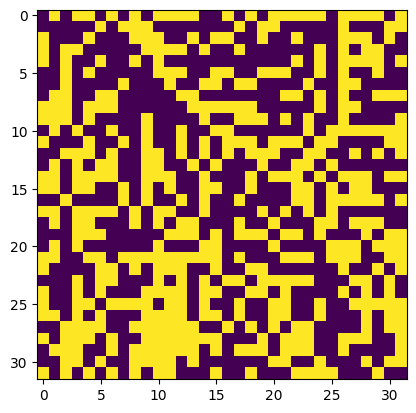

In [86]:
# img_array = np.eye(32, dtype=np.uint8)


img = Image.fromarray(best_of_generation[-1].reshape(32, 32) * 255)

plt.imshow(img)